# Konnektor - Building Ligand Networks

this is Konnektor, which you can use to construct different types of Networks.

In [ ]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -U https://github.com/conda-incubator/condacolab/archive/cuda-version-12.tar.gz
    import condacolab
    condacolab.install_mambaforge()
    !wget -q https://raw.githubusercontent.com/OpenFreeEnergy/kartograf/main/examples/environment.yaml
    !mamba env update -q --name=base --file=environment.yaml
    from google.colab import output
    output.enable_custom_widget_manager()

In [ ]:
import sys

import numpy as np
from rdkit import Chem

try:
    from openfe_benchmarks import benzenes
    from kartograf import KartografAtomMapper, MappingRMSDScorer
except ModuleNotFoundError:
    !{sys.executable} -m pip install --no-deps git+https://github.com/OpenFreeEnergy/openfe-benchmarks.git
    !{sys.executable} -m pip install --no-deps git+https://github.com/OpenFreeEnergy/kartograf.git

    from openfe_benchmarks import benzenes
    from kartograf import KartografAtomMapper, MappingRMSDScorer


components = benzenes.get_system().ligand_components

# Exclude cycle breakers! as not feasible for Hybrid topology approaches.
not_lig = ["lig_4", "lig_7", "lig_2", "lig_3"]
components = [c for c in components if(c.name not in not_lig)]

Chem.Draw.MolsToGridImage([c.to_rdkit() for c in components])

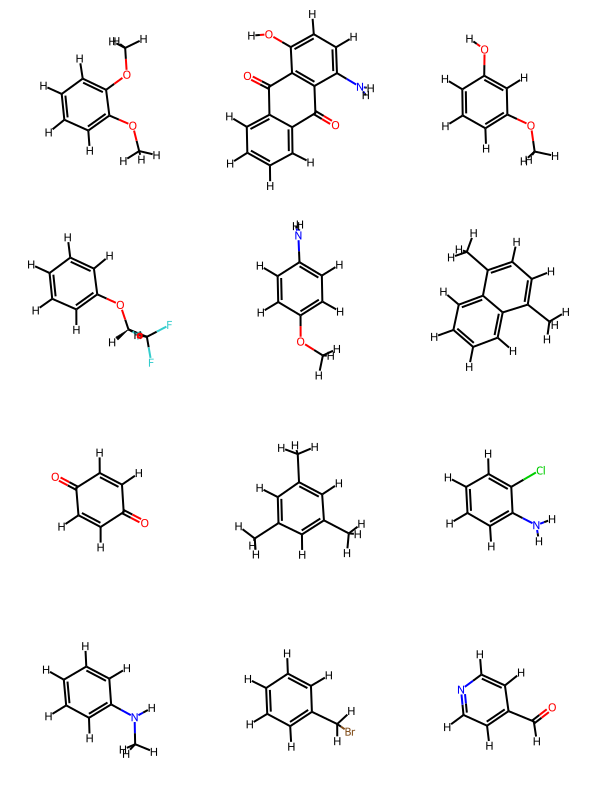

In [1]:
from konnektor.visualization import draw_ligand_network

system= benzenes.get_system()
compounds = system.ligand_components
compounds = list(filter(lambda x: not x.name in ["lig_2", "lig_3", "lig_4", "lig_7"], compounds))
Chem.Draw.MolsToGridImage ([c.to_rdkit() for c in compounds], )

In [ ]:
mapper = KartografAtomMapper()
scorer = MappingRMSDScorer()
mappings = []
for cA in compounds:
    for cB in compounds:
        mapping = next(mapper.suggest_mappings(cA, cB))
        mappings.append(mapping)

mappings



# Radial Network Layout

In [ ]:
from konnektor.network_planners import RadialLigandNetworkPlanner
ligand_network_planner = RadialLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer)

In [ ]:
radial_network = ligand_network_planner(compounds)
radial_network.name="Radial"
radial_network

In [ ]:
fig = draw_ligand_network(radial_network, title="Radial Graph");
fig.savefig(radial_network.name+"_Network.png")
fig.show()

## Starry Sky Network Layout

In [ ]:
from konnektor.network_planners import StarrySkyLigandNetworkPlanner
ligand_network_planner = StarrySkyLigandNetworkPlanner(mapper=KartografAtomMapper(), 
                                                       scorer=scorer, 
                                                       target_node_connectivity=3)

In [ ]:
starry_sky_network = ligand_network_planner(compounds)
starry_sky_network.name="Starry Sky"
starry_sky_network

In [ ]:
fig = draw_ligand_network(starry_sky_network, title="Starry Sky Graph");
fig.savefig(starry_sky_network.name+"_Network.png")
fig.show()

# Minimal Spanning Tree

In [2]:
from konnektor.network_planners import MinimalSpanningTreeLigandNetworkPlanner

ligand_network_planner = MinimalSpanningTreeLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer)


In [ ]:
mst_network = ligand_network_planner(compounds)
mst_network.name="MST"
mst_network

In [ ]:
fig = draw_ligand_network(mst_network, "MST");
fig.savefig("MST_Network.png")
fig.show()

# Cyclo Graphs

In [ ]:
from konnektor.network_planners import CyclicLigandNetworkPlanner
ligand_network_planner = CyclicLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer,
                                                    cycle_sizes=3, node_present_in_cycles=2)

In [ ]:
cyclic_network = ligand_network_planner(compounds)
cyclic_network.name="Cyclic"
cyclic_network

In [ ]:
fig = draw_ligand_network(cyclic_network);
fig.savefig(cyclic_network.name+"_Network.png")
fig.show()

# Maximally connected network

In [2]:
import logging
from konnektor.network_planners import MaximalNetworkPlanner
from kartograf.atom_mapper import logger
logger.setLevel(logging.ERROR)

ligand_network_planner = MaximalNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer)
ligand_network_planner.nprocesses = 3


In [3]:
len(compounds)*len(compounds)//2

72

In [4]:
max_network = ligand_network_planner(compounds)
max_network.name = "Max"
max_network

In [1]:
print(max_network)

NameError: name 'max_network' is not defined

In [ ]:
fig = draw_ligand_network(max_network);
fig.savefig(max_network.name+"_Network.png")
fig.show()

# Diversity Cluster Network

In [ ]:
from konnektor.network_planners import DiversityNetworkPlanner
from sklearn.cluster import KMeans
ligand_network_planner = DiversityNetworkPlanner(mapper=KartografAtomMapper(), scorer=scorer)

In [ ]:
div_network = ligand_network_planner(compounds)
div_network.name = "Diversity Cluster"
div_network

In [ ]:
fig = draw_ligand_network(div_network);
fig.savefig(div_network.name+"_Network.png")
fig.show()

# Summary

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=[9*2,3*9])
axes= np.array(axes).flat

fs = 22
for ax, net in zip(axes, [max_network, radial_network, starry_sky_network, 
                          mst_network, 
                          cyclic_network, div_network]):
    draw_ligand_network(network=net, title=net.name, ax=ax, node_size=1500)
    ax.axis("off")
axes[-1].axis("off")



In [ ]:
fig.savefig("../.img/network_layouts.png", dpi=400)

## in one cell: